### Convert df_events to meta dataframe for pyphotometry analysis
- Meant to be a bridge between the pyphotometry analysis and df_events for the time being 

In [191]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np
from trialexp.process.pycontrol.session_analysis import *
from trialexp.process.pycontrol.utils import *

In [161]:
df_events = pd.read_pickle('df_events.pkl')

### Read task definition

In [162]:
basefolder = r'C:\code\trialexp'
tasks = pd.read_csv(basefolder+'\\params\\tasks_params.csv', usecols=[1, 2, 3, 4], index_col=False)

In [163]:
from trialexp.process.pycontrol.session_analysis import Session

In [164]:
conditions, triggers, events_to_process = Session.get_task_specs(tasks, 'reaching_go_spout_incr_break2_nov22')

# extract condition from the event list
df_conditions = df_events[df_events.event_name.isin(conditions)]
df_conditions.set_index('time', inplace=True, drop=True)
df_conditions

,state,event_name,trial_number
time,,,
45.571,waiting_for_spout,spout,1
45.591,busy_win,US_end_timer,1
45.593,busy_win,US_end_timer,1
61.650,waiting_for_spout,spout,2
61.671,busy_win,US_end_timer,2
...,...,...,...
193.255,busy_win,US_end_timer,18
196.526,waiting_for_spout,spout,19
196.547,busy_win,US_end_timer,19


In [173]:
trial_window = [-2000, 4000] # time window around trigger where data are considered to be the same trial 

#TODO do each trigger separately and combine them at the end at the df_event_trials level
trigger_time = df_events[(df_events.state.isin(triggers)) & (df_events.event_name == 'state_change')].time
df_events = add_trial_nb(df_events, trigger_time,trial_window) #add trial number according to the trigger
df_events = add_time_rel_trigger(df_events, trigger_time, 'trial_time', trial_window) #calculate time relative to trigger
df_events.dropna(inplace=True)
df_events

,state,event_name,time,trial_number,trial_nb,trial_time
40,waiting_for_spout,spout,45.571,1,1.0,-0.001
41,busy_win,state_change,45.572,1,1.0,0.000
46,busy_win,US_end_timer,45.591,1,1.0,0.019
47,busy_win,US_end_timer,45.593,1,1.0,0.021
60,waiting_for_spout,spout,61.650,2,2.0,-0.001
...,...,...,...,...,...,...
529,busy_win,state_change,196.527,19,19.0,0.000
534,busy_win,US_end_timer,196.547,19,19.0,0.020
539,waiting_for_spout,spout,199.186,20,20.0,0.000
540,busy_win,state_change,199.186,20,20.0,0.000


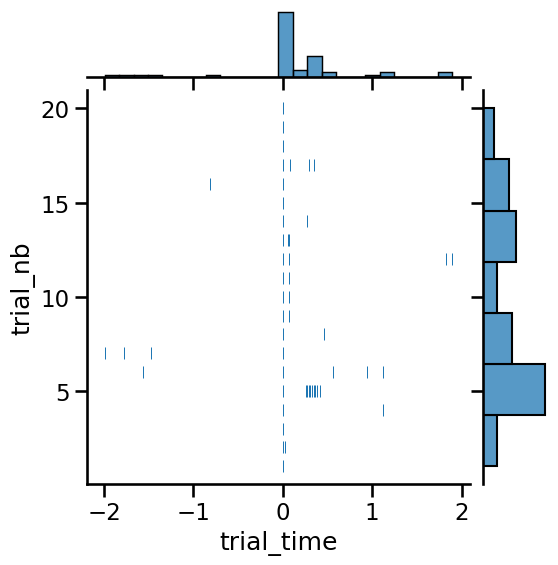

In [8]:
df2plot = df_events[df_events.event_name=='spout']
sns.set_context('talk')
sns.jointplot(x='trial_time', y='trial_nb', marker='|',data=df2plot)

`df_condition` is nothing more than a dataframe containing the timestamp and name of the condition as defined in the task file. It also contains, the name of the name of the trigger event and trial number

In [167]:
# filter the events to only focus on what we want
df_events = df_events[df_events.event_name.isin(conditions) | 
                          df_events.state.isin(triggers) & (df_events.event_name=='state_change')]
df_events

,state,event_name,time,trial_number,trial_nb,trial_time
40,waiting_for_spout,spout,45.571,1,1.0,-0.001
41,busy_win,state_change,45.572,1,1.0,0.000
46,busy_win,US_end_timer,45.591,1,1.0,0.019
47,busy_win,US_end_timer,45.593,1,1.0,0.021
60,waiting_for_spout,spout,61.650,2,2.0,-0.001
...,...,...,...,...,...,...
529,busy_win,state_change,196.527,19,19.0,0.000
534,busy_win,US_end_timer,196.547,19,19.0,0.020
539,waiting_for_spout,spout,199.186,20,20.0,0.000
540,busy_win,state_change,199.186,20,20.0,0.000


In [240]:
from trialexp.process.pycontrol.session_analysis import Session

pycontrol_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_nov22\\'
filename = 'kms062-2023-02-06-112451'
smrx_output_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_nov22\\processed\\'

session = Session(pycontrol_dir+filename+'.txt')
df_events = parse_events(session)
# df_events = pd.read_pickle('df_events.pkl')
df_events

,state,event_name,time
1,short_break,state_change,0
2,short_break,bar_off,345
3,short_break,bar,425
4,short_break,bar_off,795
5,short_break,bar,1292
...,...,...,...
550,busy_win,bar,201003
551,busy_win,bar_off,201085
552,busy_win,bar,201102
553,busy_win,bar_off,201118


In [242]:
trial_window = [-2000, 4000]
df_events_trials = extract_trial_by_trigger(df_events, triggers[0], conditions+events_to_process, 
                                            trial_window, 'test', session.datetime)
df_events_trials

,US_end_timer_trial_time,bar_trial_time,bar_off_trial_time,spout_trial_time,trial_nb,uid,timestamp,trigger,valid
trial_nb,,,,,,,,,
1.0,"[19.0, 21.0]",[3964.0],[3881.0],[-1.0],1.0,test_2023-02-06_11:24:51_1.0,45572,busy_win,True
2.0,[20.0],"[-524.0, 663.0, 745.0, 1591.0, 1657.0]","[-597.0, -127.0, 709.0, 1576.0, 1594.0]","[-1.0, 26.0]",2.0,test_2023-02-06_11:24:51_2.0,61651,busy_win,True
3.0,[21.0],"[-649.0, -577.0, -511.0, 260.0, 333.0, 787.0, ...","[-718.0, -598.0, -561.0, -115.0, 318.0, 760.0,...",[0.0],3.0,test_2023-02-06_11:24:51_3.0,111702,busy_win,True
4.0,"[21.0, 1145.0]","[382.0, 1352.0, 1455.0, 1796.0]","[-66.0, 1063.0, 1439.0, 1683.0]","[0.0, 1124.0]",4.0,test_2023-02-06_11:24:51_4.0,120058,busy_win,True
5.0,"[21.0, 275.0, 365.0]","[350.0, 769.0]","[-100.0, 700.0]","[0.0, 254.0, 271.0, 292.0, 307.0, 327.0, 344.0...",5.0,test_2023-02-06_11:24:51_5.0,128554,busy_win,True
6.0,"[-1546.0, 21.0, 582.0, 958.0, 1137.0]","[-499.0, -220.0, -161.0, -120.0, 705.0, 740.0]","[-566.0, -242.0, -202.0, -146.0, -104.0, 720.0...","[-1567.0, 0.0, 561.0, 937.0, 1116.0]",6.0,test_2023-02-06_11:24:51_6.0,131850,busy_win,True
7.0,"[-1974.0, -1761.0, -1452.0, 21.0]",NaN,NaN,"[-1995.0, -1782.0, -1474.0, 0.0]",7.0,test_2023-02-06_11:24:51_7.0,135195,busy_win,True
8.0,"[21.0, 480.0]",NaN,NaN,"[-1.0, 458.0]",8.0,test_2023-02-06_11:24:51_8.0,137566,busy_win,True
9.0,[21.0],NaN,NaN,"[-1.0, 64.0]",9.0,test_2023-02-06_11:24:51_9.0,141383,busy_win,True


In [181]:

# group events according to trial number and event name
df_events_trials = df_events.groupby(['trial_nb', 'event_name']).agg(list)
df_events_trials = df_events_trials.loc[:, ['trial_time']]
df_events_trials = df_events_trials.unstack('event_name') #convert the event names to columns

df_events_trials.columns = df_events_trials.columns.droplevel() # dropping the multiindex of the columns

if 'state_change' in df_events_trials.columns: 
    df_events_trials = df_events_trials.drop(columns=['state_change'])

# remove the column for compatibility
df_events_trials.columns = [col+'_trial_time' for col in df_events_trials.columns]

# add uuid
df_events_trials['trial_nb'] = df_events_trials.index.values
df_events_trials['uid'] = df_events_trials['trial_nb'].apply(lambda x: f'test_{x}')

# fill the new_df with timestamps of trigger and trigger types
df_events_trials['timestamp'] = trigger_time.values
df_events_trials['trigger'] = triggers[0]

# validate trials in function of the time difference between trials (must be > at length of trial_window)
df_events_trials['valid'] = df_events_trials['timestamp'].diff() > trial_window[0]

# validate first trial except if too early in the session
if df_events_trials['timestamp'].iloc[0] > abs(trial_window[0]):
   df_events_trials.loc[1, 'valid'] = True

df_events_trials

,US_end_timer_trial_time,spout_trial_time,trial_nb,uid,timestamp,trigger,valid
trial_nb,,,,,,,
1.0,"[0.01899999999999835, 0.021000000000000796]",[-0.0010000000000047748],1.0,test_1.0,45.572,busy_win,True
2.0,[0.01999999999999602],"[-0.0010000000000047748, 0.02599999999999625]",2.0,test_2.0,61.651,busy_win,True
3.0,[0.021000000000000796],[0.0],3.0,test_3.0,111.702,busy_win,True
4.0,"[0.020999999999986585, 1.144999999999996]","[0.0, 1.1239999999999952]",4.0,test_4.0,120.058,busy_win,True
5.0,"[0.020999999999986585, 0.2750000000000057, 0.3...","[0.0, 0.2539999999999907, 0.2709999999999866, ...",5.0,test_5.0,128.554,busy_win,True
6.0,"[-1.5459999999999923, 0.021000000000015007, 0....","[-1.5670000000000073, 0.0, 0.561000000000007, ...",6.0,test_6.0,131.850,busy_win,True
7.0,"[-1.9739999999999895, -1.7609999999999957, -1....","[-1.9950000000000045, -1.7819999999999823, -1....",7.0,test_7.0,135.195,busy_win,True
8.0,"[0.020999999999986585, 0.47999999999998977]","[-0.0010000000000047748, 0.4579999999999984]",8.0,test_8.0,137.566,busy_win,True
9.0,[0.020999999999986585],"[-0.0010000000000047748, 0.06399999999999295]",9.0,test_9.0,141.383,busy_win,True
